# Working with automated computations: Computed tables

Welcome back! In this session, we are going to continue working with the pipeline for the mouse calcium imaging example. 

In this session, we will learn to:

* compute various statistics for each neuron by defining a `Computed` table
* define a `Lookup` table to store parameters for computation
* define another `Computed` table to perform spike detection and store the detected spikes
* automatically trigger computations for all missing entries with `populate`
* define a `Part` table to save the results computed with the master `Computed` table

Let's import `datajoint` again.

In [1]:
import datajoint as dj

As we are going to perform some computations, let's go ahead and import NumPy and Matplotlib.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Similarly as before, to continue working with the tables we defined in the previous notebook, we can either redefine the classes for each table `Mouse`, `Session`, `Scan`, `AverageFrame` and populate them. Or, again for your convenience, we can import them from the `tutorial_pipeline.imaging` module. 

In [3]:
from tutorial_pipeline.imaging import schema, Mouse, Session, Scan, AverageFrame

[2025-01-02 16:06:46,111][INFO]: Connecting root@db:3306
[2025-01-02 16:06:46,117][INFO]: Connected root@db:3306


	Populated Scan 0 - 2017-05-15 - 1
	Populated Scan 0 - 2017-05-15 - 2
	Populated Scan 100 - 2017-05-25 - 1


In [4]:
Session()

mouse_id Unique animal ID,session_date date,experiment_setup experiment setup ID,experimenter experimenter name,data_path
0,2017-05-15,0,Edgar Y. Walker,/workspaces/datajoint-tutorials/data
0,2017-05-19,0,Edgar Y. Walker,/workspaces/datajoint-tutorials/data
5,2017-01-05,1,Fabian Sinz,/workspaces/datajoint-tutorials/data
100,2017-05-25,100,Jacob Reimer,/workspaces/datajoint-tutorials/data


In [5]:
Scan()

mouse_id Unique animal ID,session_date date,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,2017-05-15,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,2017-05-15,2,200.0,920.0,24.0,15.0,example_scan_02.tif
100,2017-05-25,1,150.0,920.0,25.0,15.0,example_scan_03.tif


In [6]:
AverageFrame()

mouse_id Unique animal ID,session_date date,scan_idx scan index,average_frame average fluorescence across frames
0,2017-05-15,1,=BLOB=
0,2017-05-15,2,=BLOB=
100,2017-05-25,1,=BLOB=


The `imaging.py` also fill each table by inserting manually and loading data from the external tiff files.

## Computations in data pipeline

Now it's time to perform more complicated analyses. 

When you perform computations in the DataJoint data pipeline, you focus and design tables in terms of **what** is it that you are computing rather than the **how**. You should think in terms of the "things" that you are computing!

Now, we would like to detect cells from the average image. The final product we would like is the binary **mask** for each individual cell, with the 1 in the region of interest (ROI) and 0 in other places.

So the new "thing" or entity here is `Roi`, where each entry corresponds the mask of one ROI. Let's start designing the table, paying special attention to the dependencies.

## Detect cells from the average fluorescence image

Now let's perform the segmentation to isolate ROIs. Let's start by taking a look at one average fluoresence image.

In [7]:
keys = AverageFrame.fetch("KEY")

# pick one key
key = keys[0]

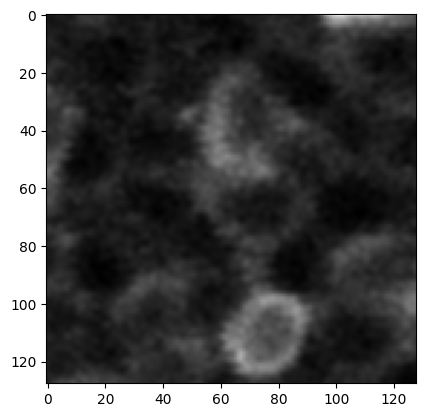

In [15]:
# ENTER YOUR CODE! - preview an AverageFrame for a particular key
avg_image = (AverageFrame & key).fetch1('average_frame')
plt.imshow(avg_image, cmap=plt.cm.gray)

In [16]:
avg_image = AverageFrame.fetch("average_frame")

In [17]:
avg_image

array([array([[32.73, 30.77, 31.74, ..., 65.76, 62.77, 58.65],
              [30.07, 27.96, 28.74, ..., 60.11, 58.1 , 54.59],
              [28.91, 27.02, 27.12, ..., 58.01, 56.1 , 53.25],
              ...,
              [35.17, 35.56, 34.37, ..., 21.08, 21.45, 21.09],
              [33.14, 35.73, 37.64, ..., 20.42, 21.24, 21.51],
              [33.52, 37.65, 41.71, ..., 19.82, 20.29, 21.36]], shape=(128, 128)),
       array([[ 29.53,  30.8 ,  30.96, ..., 230.09, 230.78, 228.19],
              [ 29.61,  29.69,  30.71, ..., 224.86, 227.21, 227.22],
              [ 29.61,  28.28,  30.19, ..., 220.51, 224.43, 224.85],
              ...,
              [ 23.67,  23.05,  24.06, ...,  32.54,  32.07,  35.28],
              [ 24.03,  22.45,  22.4 , ...,  31.67,  30.75,  32.72],
              [ 25.78,  23.27,  21.92, ...,  31.12,  31.29,  32.94]],
             shape=(128, 128))                                       ,
       array([[41.55, 40.2 , 38.3 , ..., 55.67, 57.17, 58.65],
              [

It's a bit subtle, but `fetch` returns a NumPy array of the attribute, even if the attribute contains a NumPy array. So here, we actually got a NumPy array of NumPy array. We can of course just index into it,

In [18]:
avg_image[0]

array([[32.73, 30.77, 31.74, ..., 65.76, 62.77, 58.65],
       [30.07, 27.96, 28.74, ..., 60.11, 58.1 , 54.59],
       [28.91, 27.02, 27.12, ..., 58.01, 56.1 , 53.25],
       ...,
       [35.17, 35.56, 34.37, ..., 21.08, 21.45, 21.09],
       [33.14, 35.73, 37.64, ..., 20.42, 21.24, 21.51],
       [33.52, 37.65, 41.71, ..., 19.82, 20.29, 21.36]], shape=(128, 128))

but if we knew that there was only one item, we can use `fetch1` instead to save some trouble

In [19]:
avg_image = (AverageFrame & key).fetch1("average_frame")

In [20]:
avg_image

array([[32.73, 30.77, 31.74, ..., 65.76, 62.77, 58.65],
       [30.07, 27.96, 28.74, ..., 60.11, 58.1 , 54.59],
       [28.91, 27.02, 27.12, ..., 58.01, 56.1 , 53.25],
       ...,
       [35.17, 35.56, 34.37, ..., 21.08, 21.45, 21.09],
       [33.14, 35.73, 37.64, ..., 20.42, 21.24, 21.51],
       [33.52, 37.65, 41.71, ..., 19.82, 20.29, 21.36]], shape=(128, 128))

Let's plot to take a quick look:

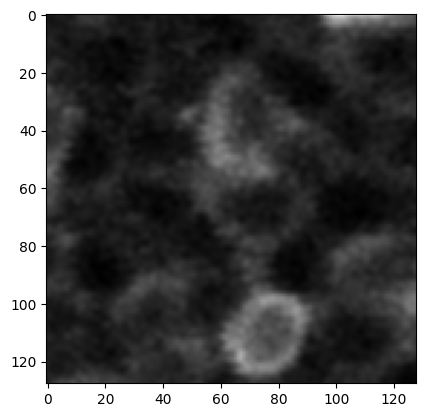

In [21]:
plt.imshow(avg_image, cmap=plt.cm.gray)

There are multiple ways to perform the segmentation. To keep it simple, we just detect the cells by setting up the threshold on the average image.

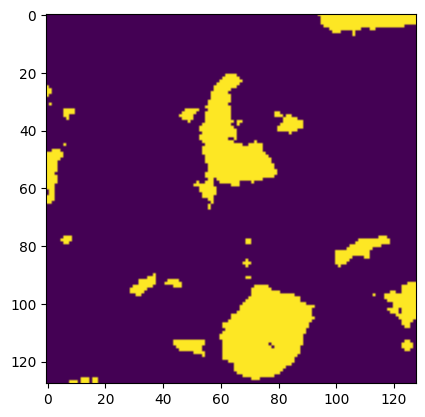

In [22]:
threshold = 50
mask = avg_image > threshold
plt.imshow(mask)

The outcome is different across different thresholds we set. Therefore, this threshold is a parameter we could potentially tweak.

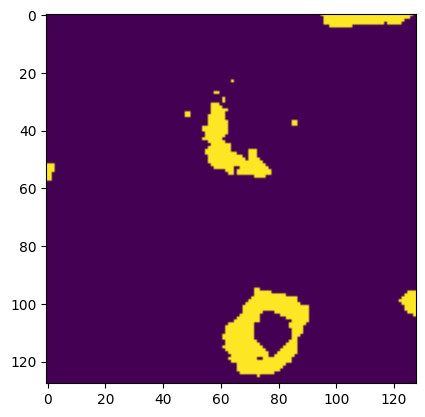

In [23]:
threshold = 60
mask = avg_image > threshold
plt.imshow(mask)

Now we could use scipy.ndimage to detect the blobs from this binary mask

For the detailed tutorial, please refer to https://scipy-lectures.org/advanced/image_processing/index.html#segmentation

In [24]:
from scipy import ndimage

The method `label` marks each blob with different number, `label_im` is the image with different blobs marked with different number and `nb_labels` is the number of blobs that are detected

10


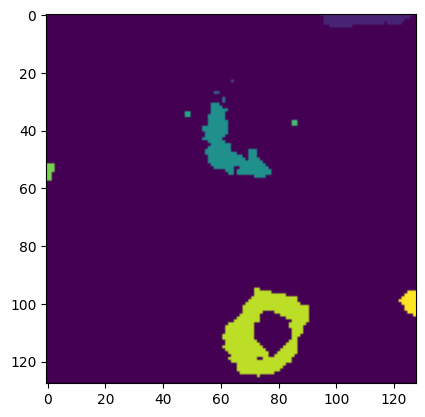

In [25]:
label_im, nb_labels = ndimage.label(mask)
print(nb_labels)
plt.imshow(label_im)

In [26]:
np.unique(label_im)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

0 marks the background and 1 to 10 mark the detected blobs. Some of these are too small to be cells. We could set a cutoff on size to filter out the small blobs. Here the cutoff is another parameter that could be tweaked.

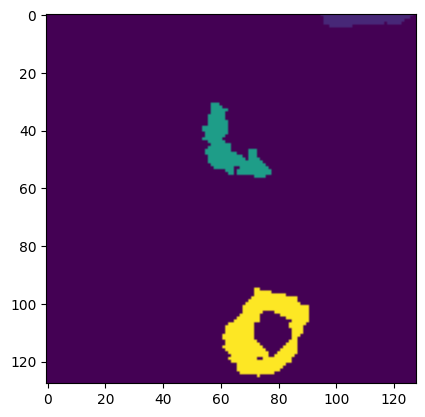

In [27]:
size_cutoff = 50
sizes = np.array([np.sum(label_im == i) for i in np.unique(label_im)])

small_size_filter = sizes < size_cutoff
pixel_to_remove = small_size_filter[label_im]

label_im[pixel_to_remove] = 0
plt.imshow(label_im)

Now there are only two blobs left.

Next let's separate out each mask.

In [28]:
rois = []
for i in np.unique(label_im)[1:]:  # 0 is the background
    rois.append(label_im == i)

There are two special notes about the analyses we performed above.
1. The segmentation results are dependent on the parameters `threshold` and `size_cutoff`. Rather than fixing the value of the threshold, we might want to try different values and see what works well.
2. For the segemtation analyses of each `AverageFrame`, the result is a number of ROIs instead of one. We need to perform the analyses on the level of each `AverageFrame`, but save the result on the granularity of each `Roi`.

Next we would like to introduce two DataJoint table tiers to help handling these two needs.

## Parameter `Lookup` table

We would like to perform the segmentation for a **combination** of `AverageFrame`s and different set of parameters of `threshold` and `size_cutoff` values. To do this while still taking advantage of the `make` and `populate` logic, you would want to define a table to house parameters for segmentation in a `Lookup` table!

Let's define `Param` table to hold different parameter configuration for our spike detection algorithm. We are going to define this table as a `Lookup` table, rather than a `Manual` table. By now, you know that `Lookup` must be yet another **table tier** in DataJoint. `Lookup` tables are depicted by gray boxes in the Diagram.

This tier indicates that the table will contain information:
* that will be referenced by other tables
* that doesn't change much - usually contains a few pre-known entries

In [29]:
@schema
class SegmentationParam(dj.Lookup):
    definition = """
    seg_param_id        : int      # unique id for cell segmentation parameter set
    ---
    threshold           : float
    size_cutoff         : float
    """

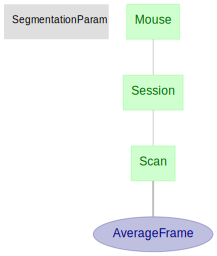

In [30]:
dj.Diagram(schema)

So far the `SegmentationParam` is an extra table that did not relate with any of the existing, but the `Segmentation` will depend on this table.

## Master `Computed` table `Segmentation` and `Part` table for `Roi`

As mentioned above, we performed the segmentation processing on each `AverageFrame`, but the product is the masks of each ROI. In this case, we could create a `Computed` table `Segmentation` containing the `make` method to drive the processing, while using a `Part` table to save results into `Roi`.

`Computed` table and `Part` table are another two table tiers like `Manual`, `Lookup`, and `Imported` we introduced previously.  

`Computed` table is very similar to the `Imported` table, which also supports the definition of `make` function and `populate`. The only difference is that the computation in an `Imported` table is dependent on external data, while the computation in a `Computed` table only depends on data inside the database.

Contents in a `Part` table is dependent on its **master** table and the master table could be any type of table. This current example is a very typical usage of Part table. The master `Computed` serves as the driver for computation and the major results with a smaller granularity are saved in the `Part` table.

In [31]:
@schema
class Segmentation(dj.Computed):
    definition = """
    -> AverageFrame
    -> SegmentationParam
    ---
    segmented_masks         : longblob   # overview of segmented masks
    """

    class Roi(dj.Part):
        definition = """
        -> master
        roi_idx             : int        # index of an roi
        ---
        mask                : longblob   # mask of this roi
        """

Notice that in the definition of `Roi`, apart from inheriting the primary from its master table `Segmentation`, the Roi has another primary key attribute `roi_idx`. The relationship between `Segmentation` and `Roi` is **one-to-many**.

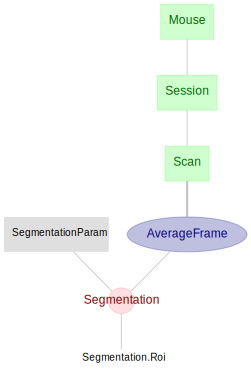

In [32]:
dj.Diagram(schema)

The `Computed` table is labeled as a pink oval and the `Part` table is bare text. We see that `Segmentation` is a `Computed` table that depends on **both AverageFrame and SegmentationParam**. Finally, let's go ahead and implement the `make` method for the `Segmentation` table. 

In [33]:
@schema
class Segmentation(dj.Computed):
    definition = """
    -> AverageFrame
    -> SegmentationParam
    ---
    segmented_masks         : longblob   # overview of segmented masks
    """

    class Roi(dj.Part):
        definition = """
        -> master
        roi_idx             : int        # index of an roi
        ---
        mask                : longblob   # mask of this roi
        """

    def make(
        self, key
    ):  # key is one of the primary keys of the join product of AverageFrame and ParameterSet
        print("Populating for: ", key)

        # fetch average image from the previous table AverageFrame
        avg_image = (AverageFrame & key).fetch1("average_frame")

        # fetch the parameters threshold and size_cutoff
        threshold, size_cutoff = (SegmentationParam & key).fetch1(
            "threshold", "size_cutoff"
        )

        # perform the thresholding and blob detection
        mask = avg_image > threshold
        label_im, nb_labels = ndimage.label(mask)
        sizes = np.array([np.sum(label_im == i) for i in np.unique(label_im)])

        small_size_filter = sizes < size_cutoff
        pixel_to_remove = small_size_filter[label_im]

        label_im[pixel_to_remove] = 0

        rois = []
        for i in np.unique(label_im)[1:]:  # 0 is the background
            rois.append(
                dict(
                    **key,  # inherit primary key from master table
                    roi_idx=i,
                    mask=label_im == i
                )
            )

        # insert into the master table first
        self.insert1(dict(**key, segmented_masks=label_im))
        print("Detected {} ROIs!\n".format(len(rois)))
        # then insert into the part table
        self.Roi.insert(rois)

The implementation of the segmentation is pretty much what we had above, except that we now fetch the value of `threshold` and `size_cutoff` from the `SegmentationParam` table.

**Important note: always insert into the master table first and then insert the corresponding entries in the part table.** If a master table entry does not exist, its corresponding entries would not be valid.

Looking at the `Segmentation` table, we see that it indeed inherits the primary key attributes from **both AverageFrame (`mouse_id`, `session_date`, `scan_idx`) and SegmentationParam (`seg_param_id`)**.

In [34]:
Segmentation()

mouse_id Unique animal ID,session_date date,scan_idx scan index,seg_param_id unique id for cell segmentation parameter set,segmented_masks overview of segmented masks


And for the part table `Segmentation.Roi`, there was an additional primary key attribute `roi_idx`:`

In [35]:
Segmentation.Roi()

mouse_id Unique animal ID,session_date date,scan_idx scan index,seg_param_id unique id for cell segmentation parameter set,roi_idx index of an roi,mask mask of this roi


### Populating `Segmentation` table

We are now ready to populate! When we call `populate` on `Segmentation`, DataJoint will automatically call `make` on **every valid combination of the parent tables - AverageFrame and SegmentationParam**.

In [36]:
# ENTER YOUR CODE! - populate the Segmentation table
Segmentation.populate()

{'success_count': 0, 'error_list': []}

Hm... `populate` doesn't seem to be doing anything... What could be the cause?

Looking at `SegmentationParam` reveals the issue:

In [37]:
SegmentationParam()

seg_param_id unique id for cell segmentation parameter set,threshold,size_cutoff


That's right! We have not added a parameter set yet. Let's go ahead and add one.

In [38]:
SegmentationParam.insert1((0, 50, 50))

In [39]:
SegmentationParam()

seg_param_id unique id for cell segmentation parameter set,threshold,size_cutoff
0,50.0,50.0


Now we should really be ready to perform the computation...

In [40]:
# ENTER YOUR CODE! - populate the Segmentation table for real!
Segmentation.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'scan_idx': 1, 'seg_param_id': 0}
Detected 6 ROIs!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'scan_idx': 2, 'seg_param_id': 0}
Detected 6 ROIs!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'scan_idx': 1, 'seg_param_id': 0}
Detected 9 ROIs!



{'success_count': 3, 'error_list': []}

In [41]:
Segmentation()

mouse_id Unique animal ID,session_date date,scan_idx scan index,seg_param_id unique id for cell segmentation parameter set,segmented_masks overview of segmented masks
0,2017-05-15,1,0,=BLOB=
0,2017-05-15,2,0,=BLOB=
100,2017-05-25,1,0,=BLOB=


...and we now have spike detection running!

### Trying out other parameter values

Let's see how different thresholds affect the results.

In [42]:
SegmentationParam.insert1((1, 60, 50))  # add another threshold and size cutoff

In [43]:
SegmentationParam()

seg_param_id unique id for cell segmentation parameter set,threshold,size_cutoff
0,50.0,50.0
1,60.0,50.0


In [44]:
# ENTER YOUR CODE! - populate the "missing" entry in Segmentation table
Segmentation.populate()

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'scan_idx': 1, 'seg_param_id': 1}
Detected 3 ROIs!

Populating for:  {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'scan_idx': 2, 'seg_param_id': 1}
Detected 2 ROIs!

Populating for:  {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'scan_idx': 1, 'seg_param_id': 1}
Detected 3 ROIs!



{'success_count': 3, 'error_list': []}

In [45]:
Segmentation()

mouse_id Unique animal ID,session_date date,scan_idx scan index,seg_param_id unique id for cell segmentation parameter set,segmented_masks overview of segmented masks
0,2017-05-15,1,0,=BLOB=
0,2017-05-15,1,1,=BLOB=
0,2017-05-15,2,0,=BLOB=
0,2017-05-15,2,1,=BLOB=
100,2017-05-25,1,0,=BLOB=
100,2017-05-25,1,1,=BLOB=


You can see that the results of segmentation under different parameter settings can live happily next to each other, without any confusion as to what is what.

## Deleting entries from "upstream"

Now let's say that we decided that we don't like the first threshold of `50`. While there is really nothing wrong keeping those results around, you might decide that you'd rather delete all computations performed with that threshold to keep your tables clean.

While you can restrict `Segmentation` table to the specific parameter id (i.e. `seg_param_id = 0`) and delete the entries:

In [46]:
# Select 'No' when it pops up
(Segmentation & "seg_param_id = 0").delete()

[2025-01-02 16:28:40,083][INFO]: Deleting 21 rows from `root_tutorial_pipeline`.`__segmentation__roi`
[2025-01-02 16:28:40,089][INFO]: Deleting 3 rows from `root_tutorial_pipeline`.`__segmentation`
[2025-01-02 16:28:42,915][INFO]: Deletes committed.


3

We can simply delete the unwanted parameter from the `SegmentationParam` table, and let DataJoint cascade the deletion:

In [47]:
SegmentationParam & "seg_param_id = 0"

seg_param_id unique id for cell segmentation parameter set,threshold,size_cutoff
0,50.0,50.0


In [48]:
(SegmentationParam() & "seg_param_id = 0").delete()

[2025-01-02 16:29:07,087][INFO]: Deleting 1 rows from `root_tutorial_pipeline`.`#segmentation_param`
[2025-01-02 16:29:09,713][INFO]: Deletes committed.


1

In [49]:
Segmentation()

mouse_id Unique animal ID,session_date date,scan_idx scan index,seg_param_id unique id for cell segmentation parameter set,segmented_masks overview of segmented masks
0,2017-05-15,1,1,=BLOB=
0,2017-05-15,2,1,=BLOB=
100,2017-05-25,1,1,=BLOB=


### Visualize ROIs

Now we have all ROI masks saved in the table `Segmentation.Roi`, let's quickly look at an example by fetching the `mask` from the table.

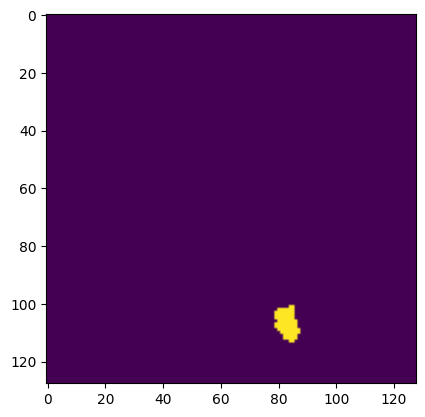

In [50]:
# show one example ROI
masks = (Segmentation.Roi).fetch("mask")
plt.imshow(masks[4])

## Fluorescence trace of each segmented ROI

Now we got masks of ROIs in the table `Segmetation.Roi` obtained with different parameter combinations. We would like to extract the fluorescence trace of each segmentation. 

The table design is similar to the `Segmentation` and `Roi`. The master table `Fluorescence` is the driver for the computation, with a secondary attribute `time` shared across traces of all ROIs. The part table `Trace` saves the extracted trace for each ROI over time (frame). 

In [51]:
from skimage import io
import os


@schema
class Fluorescence(
    dj.Imported
):  # imported table because it also rely on the external tiff file.
    definition = """
    -> Segmentation
    ---
    time    : longblob    # time for each frame
    """

    class Trace(dj.Part):
        definition = """
        -> master
        -> Segmentation.Roi
        ---
        trace      :  longblob    # fluorescence trace of each ROI
        """

    # the master table is mainly to perform the computation, while the part table contains the result
    def make(self, key):
        print("Populating: {}".format(key))
        # fetch data directory from table Session
        data_path = (Session & key).fetch1("data_path")

        # fetch data file name from table Scan
        file_name = (Scan & key).fetch1("file_name")

        # load the file
        im = io.imread(os.path.join(data_path, file_name))

        # get dimensions of the image and reshape
        n, w, h = np.shape(im)
        im_reshaped = np.reshape(im, [n, w * h])

        # get frames per second to compute time
        fps = (Scan & key).fetch1("fps")

        # insert into master table first
        self.insert1(dict(**key, time=np.array(range(n)) / fps))

        # extract traces
        roi_keys, masks = (Segmentation.Roi & key).fetch("KEY", "mask")

        traces = []
        for roi_key, mask in zip(roi_keys, masks):
            # reshape mask
            mask_reshaped = np.reshape(mask, [w * h])
            trace = np.mean(im_reshaped[:, mask_reshaped], axis=1)

            traces.append(dict(**roi_key, trace=trace))

        self.Trace.insert(traces)

In [52]:
# ENTER YOUR CODE! - populate the Fluorescence table
Fluorescence.populate()

Populating: {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'scan_idx': 1, 'seg_param_id': 1}
Populating: {'mouse_id': 0, 'session_date': datetime.date(2017, 5, 15), 'scan_idx': 2, 'seg_param_id': 1}
Populating: {'mouse_id': 100, 'session_date': datetime.date(2017, 5, 25), 'scan_idx': 1, 'seg_param_id': 1}


{'success_count': 3, 'error_list': []}

Now we could plot the traces of an example scan

Text(0, 0.5, 'Fluorescence')

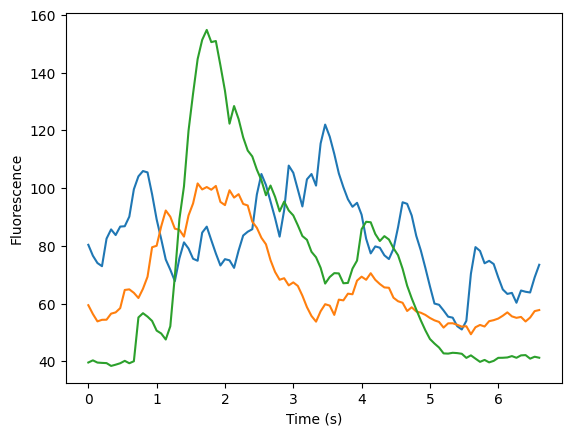

In [56]:
key = dict(mouse_id=0, session_number=1, scan_idx=1, seg_param_id=1)

# ENTER YOUR CODE! - fetch 'time' from the Fluorescence table using fetch1()
time = (Fluorescence & key).fetch1('time')

# ENTER YOUR CODE! - fetch 'trace' from the Fluorescence.Trace table using fetch()
traces = (Fluorescence.Trace() & key).fetch('trace')

plt.plot(time, np.vstack(traces).T)
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence')

## Summary

Congratulations! You have successfully extended your pipeline with all types of tables. This pipeline is simple, but reflecting a typical preprocessin pipeline of calcium imaging. We have all the table tiers and major dependencies between DataJoint tables.

**Table tiers**:  
Manual table: green box  
Lookup table: gray box  
Imported table: blue oval  
Computed table: red circle  
Part table: plain text

**Dependencies**:  
One-to-one primary: thick solid line, share the exact same primary key  
One-to-many primary: thin solid line, inherit the primary key from the parent table, but have additional field(s) as part of the primary key as well

In [ ]:
dj.Diagram(schema)

We have covered most of the building elements of data pipeline design. Using these elements, we could design more sophiscated pipelines that facillitates your experimental recordings and data analyses. To see these concepts in the context of another methodology, see the next folder on [Electrophysiology](../02-Electrophysiology)